# Sequence to Sequence attention model for machine translation

This notebook trains a sequence to sequence (seq2seq) model with two different attentions implemented for Spanish to English translation.

The codes are built on TensorFlow Core tutorials: https://www.tensorflow.org/tutorials/text/nmt_with_attention

In [36]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

2.2.0





# Load data set




*   Clean the sentences by removing special characters.
*   Add a start and end token to each sentence.
*   Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
*   Pad each sentence to a maximum length.

In [37]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [38]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",","¿")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  # remove extra space
  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [39]:
en_sentence = u"May I borrow this @ book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))
print(preprocess_sentence(sp_sentence).encode("UTF-8"))

<start> may i borrow this book ? <end>
<start> ¿ puedo tomar prestado este libro ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [40]:
# Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
  return zip(*word_pairs)

en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])
print(len(en), len(sp))

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>
118964 118964


In [41]:
# Tokenize the sentence into list of words(integers) and pad the sequence to the same length
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
  return tensor, lang_tokenizer

In [42]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [43]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
print(max_length_targ, max_length_inp)

11 16


In [44]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))
print(input_tensor_train[0])
print(target_tensor_train[0])

24000 24000 6000 6000
[  1 284  49 363  85   3   2   0   0   0   0   0   0   0   0   0]
[  1  94  19 543  20   3   2   0   0   0   0]


# Create a tf.data datasest

The tf.data.Dataset API supports writing descriptive and efficient input pipelines. Dataset usage follows a common pattern:


*   Create a source dataset from your input data.
*   Apply dataset transformations to preprocess the data.
*   Iterate over the dataset and process the elements.

Iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.

In [45]:
# Configuration 
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256  # for word embedding
units = 1024  # for GRU hidden state dimensions
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
validation_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

# Basic seq2seq model: encoder and decoder

Model groups layers into an object with training and inference features. Two ways to define tf model:

![alt text](https://i.ibb.co/c8JX8Cc/tf-Model.jpg)

Basic sequence to sequence model without attention:
![alt text](https://i.ibb.co/QN0tyMp/seq2seq.jpg)



In [46]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,  # Whether to return the last output in the output sequence, or the full sequence. 
                                   return_state=True,  # Whether to return the last state in addition to the output.
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [47]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [48]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)


  def call(self, x, hidden, enc_output):
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)
    return x, state

In [49]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


# Dot-product attention

![alt text](https://i.ibb.co/TvhM1Z2/attention.jpg)

![alt text](https://i.ibb.co/bvrcptV/dotproduct.jpg)

In [50]:
class DotProductAttention(tf.keras.layers.Layer):
  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # inner product, score shape == (batch_size, max_length)
    score = query_with_time_axis * values
    score = tf.reduce_sum(score, axis=2)
    score = tf.expand_dims(score, 2)
    
    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=0)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [51]:
attention_layer = DotProductAttention()
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


# Additive attention

![alt text](https://i.ibb.co/BqDYNP1/additive.jpg)

In [52]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(query_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

# Decoder layer with attention

![alt text](https://i.ibb.co/ZM25Zvv/Context-Vector.jpg)

In [53]:
class DecoderWithAttention(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, attention_layer = None):
    super(DecoderWithAttention, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = attention_layer

  def call(self, x, hidden, enc_output):
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    attention_weights = None
    
    if self.attention:
      # enc_output shape == (batch_size, max_length, hidden_size)
      context_vector, attention_weights = self.attention(hidden, enc_output)
      # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
      x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

# Define loss function

Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. 
![alt text](https://i.ibb.co/GtD1vc9/cross-entropy.png)

In [54]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0)) #convert 0, 1 to bool
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

# Training

@tf.function
In TensorFlow 2, eager execution is turned on by default. The user interface is intuitive and flexible (running one-off operations is much easier and faster), but this can come at the expense of performance and deployability. It is recommended to debug in eager mode, then decorate with @tf.function for better performance.

In TensorFlow 2.0, users should refactor their code into smaller functions which are called as needed. In general, it's not necessary to decorate each of these smaller functions with tf.function; only use tf.function to decorate high-level computations - for example, one step of training, or the forward pass of your model.

TensorFlow provides the tf.GradientTape API for automatic differentiation; that is, computing the gradient of a computation with respect to some inputs, usually tf.Variables. TensorFlow "records" relevant operations executed inside the context of a tf.GradientTape onto a "tape". TensorFlow then uses that tape to compute the gradients of a "recorded" computation using reverse mode differentiation.

In [55]:
optimizer = tf.keras.optimizers.Adam()

def get_train_step_func():

  @tf.function
  def train_step(inp, targ, enc_hidden, encoder, decoder):
    loss = 0

    with tf.GradientTape() as tape: # for automatic differentiation
      enc_output, enc_hidden = encoder(inp, enc_hidden)

      dec_hidden = enc_hidden

      dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

      # Teacher forcing - feeding the target as the next input
      for t in range(1, targ.shape[1]):
        # passing enc_output to the decoder
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

        loss += loss_function(targ[:, t], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss
    
  return train_step
    

In [56]:
def caculate_validation_loss(inp, targ, enc_hidden, encoder, decoder):
  loss = 0
  enc_output, enc_hidden = encoder(inp, enc_hidden)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

  # Teacher forcing - feeding the target as the next input
  for t in range(1, targ.shape[1]):
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
    loss += loss_function(targ[:, t], predictions)
    dec_input = tf.expand_dims(targ[:, t], 1)

  loss = loss / int(targ.shape[1])
  return loss

In [57]:
def training_seq2seq(epochs, attention):
  encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
  decoder = DecoderWithAttention(vocab_tar_size, embedding_dim, units, BATCH_SIZE, attention)
  train_step_func = get_train_step_func()
  training_loss = []
  validation_loss = []

  for epoch in range(epochs):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
      batch_loss = train_step_func(inp, targ, enc_hidden, encoder, decoder)
      total_loss += batch_loss

      if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                    batch,
                                                    batch_loss / int(targ.shape[0])))
    enc_hidden = encoder.initialize_hidden_state()
    total_val_loss = 0
    for (batch, (inp, targ)) in enumerate(validation_dataset.take(steps_per_epoch)):
      val_loss = caculate_validation_loss(inp, targ, enc_hidden, encoder, decoder)
      total_val_loss += val_loss

    training_loss.append(total_loss / len(input_tensor_train))
    validation_loss.append(total_val_loss / len(input_tensor_val))
    print('Epoch {} Loss {:.4f} Validation Loss {:.4f}'.format(epoch + 1,
                                        training_loss[-1], validation_loss[-1]))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
  return encoder, decoder, training_loss, validation_loss

## Training seq2seq without attention



In [58]:
epochs = 10
attention = None

print("Running seq2seq model without attention")
encoder, decoder, training_loss, validation_loss = training_seq2seq(epochs, attention)

tloss = training_loss
vloss = validation_loss

Running seq2seq model without attention
Epoch 1 Batch 0 Loss 0.0715
Epoch 1 Batch 100 Loss 0.0360
Epoch 1 Batch 200 Loss 0.0326
Epoch 1 Batch 300 Loss 0.0297
Epoch 1 Loss 0.0351 Validation Loss 0.0295
Time taken for 1 epoch 26.813003301620483 sec

Epoch 2 Batch 0 Loss 0.0288
Epoch 2 Batch 100 Loss 0.0300
Epoch 2 Batch 200 Loss 0.0288
Epoch 2 Batch 300 Loss 0.0272
Epoch 2 Loss 0.0284 Validation Loss 0.0283
Time taken for 1 epoch 20.39032006263733 sec

Epoch 3 Batch 0 Loss 0.0269
Epoch 3 Batch 100 Loss 0.0276
Epoch 3 Batch 200 Loss 0.0269
Epoch 3 Batch 300 Loss 0.0267
Epoch 3 Loss 0.0270 Validation Loss 0.0278
Time taken for 1 epoch 20.03193759918213 sec

Epoch 4 Batch 0 Loss 0.0266
Epoch 4 Batch 100 Loss 0.0260
Epoch 4 Batch 200 Loss 0.0281
Epoch 4 Batch 300 Loss 0.0262
Epoch 4 Loss 0.0261 Validation Loss 0.0277
Time taken for 1 epoch 19.89475727081299 sec

Epoch 5 Batch 0 Loss 0.0246
Epoch 5 Batch 100 Loss 0.0268
Epoch 5 Batch 200 Loss 0.0255
Epoch 5 Batch 300 Loss 0.0268
Epoch 5 Loss 

## Training seq2seq with dot product attention

In [59]:
attention = DotProductAttention()
print("Running seq2seq model with dot product attention")
encoder_dp, decoder_dp, training_loss, validation_loss = training_seq2seq(epochs, attention)

tloss = np.vstack((tloss, training_loss))
vloss = np.vstack((vloss, validation_loss))

Running seq2seq model with dot product attention
Epoch 1 Batch 0 Loss 0.0717
Epoch 1 Batch 100 Loss 0.0308
Epoch 1 Batch 200 Loss 0.0289
Epoch 1 Batch 300 Loss 0.0258
Epoch 1 Loss 0.0310 Validation Loss 0.0271
Time taken for 1 epoch 42.122215270996094 sec

Epoch 2 Batch 0 Loss 0.0264
Epoch 2 Batch 100 Loss 0.0247
Epoch 2 Batch 200 Loss 0.0254
Epoch 2 Batch 300 Loss 0.0246
Epoch 2 Loss 0.0254 Validation Loss 0.0257
Time taken for 1 epoch 34.2702202796936 sec

Epoch 3 Batch 0 Loss 0.0228
Epoch 3 Batch 100 Loss 0.0238
Epoch 3 Batch 200 Loss 0.0234
Epoch 3 Batch 300 Loss 0.0234
Epoch 3 Loss 0.0237 Validation Loss 0.0252
Time taken for 1 epoch 34.64399003982544 sec

Epoch 4 Batch 0 Loss 0.0212
Epoch 4 Batch 100 Loss 0.0230
Epoch 4 Batch 200 Loss 0.0243
Epoch 4 Batch 300 Loss 0.0216
Epoch 4 Loss 0.0227 Validation Loss 0.0251
Time taken for 1 epoch 34.40078353881836 sec

Epoch 5 Batch 0 Loss 0.0216
Epoch 5 Batch 100 Loss 0.0228
Epoch 5 Batch 200 Loss 0.0215
Epoch 5 Batch 300 Loss 0.0220
Epoch

## Training seq2seq with Bahdanau attention

In [67]:
epochs = 10

attention = BahdanauAttention(units)
print("Running seq2seq model with Bahdanau attention")
encoder_bah, decoder_bah, training_loss, validation_loss = training_seq2seq(epochs, attention)

tloss = np.vstack((tloss, training_loss))
vloss = np.vstack((vloss, validation_loss))

Running seq2seq model with Bahdanau attention
Epoch 1 Batch 0 Loss 0.0732
Epoch 1 Batch 100 Loss 0.0289
Epoch 1 Batch 200 Loss 0.0259
Epoch 1 Batch 300 Loss 0.0231
Epoch 1 Loss 0.0285 Validation Loss 0.0231
Time taken for 1 epoch 51.79730463027954 sec

Epoch 2 Batch 0 Loss 0.0204
Epoch 2 Batch 100 Loss 0.0217
Epoch 2 Batch 200 Loss 0.0203
Epoch 2 Batch 300 Loss 0.0211
Epoch 2 Loss 0.0206 Validation Loss 0.0203
Time taken for 1 epoch 42.479480266571045 sec

Epoch 3 Batch 0 Loss 0.0179
Epoch 3 Batch 100 Loss 0.0183
Epoch 3 Batch 200 Loss 0.0154
Epoch 3 Batch 300 Loss 0.0171
Epoch 3 Loss 0.0169 Validation Loss 0.0184
Time taken for 1 epoch 42.96311354637146 sec

Epoch 4 Batch 0 Loss 0.0133
Epoch 4 Batch 100 Loss 0.0146
Epoch 4 Batch 200 Loss 0.0133
Epoch 4 Batch 300 Loss 0.0137
Epoch 4 Loss 0.0137 Validation Loss 0.0169
Time taken for 1 epoch 42.734049558639526 sec

Epoch 5 Batch 0 Loss 0.0104
Epoch 5 Batch 100 Loss 0.0119
Epoch 5 Batch 200 Loss 0.0116
Epoch 5 Batch 300 Loss 0.0111
Epoch 

Text(0.5, 1.0, 'Validation loss')

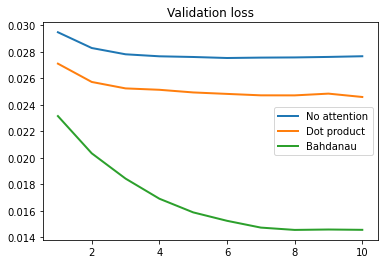

In [68]:
import matplotlib.pyplot as plt

ax = plt.subplot(111) 
t = np.arange(1, epochs+1)

for i in range(0, vloss.shape[0]):
  line, = plt.plot(t, vloss[i,:], lw=2)

ax.legend(('No attention', 'Dot product', 'Bahdanau'))
ax.set_title("Validation loss")


# Translation

In [80]:
def translate(sentence, encoder, decoder):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    # until the predicted word is <end>.
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence

    # the predicted ID is fed back into the model, no teacher forcing.
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence

In [83]:
result, sentence = translate(u'esta es mi vida.', encoder_bah, decoder_bah)
print('Input: %s' % (sentence))
print('Predicted translation: {}'.format(result))

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


In [84]:
result, sentence = translate(u'¿todavia estan en casa?', encoder_bah, decoder_bah)
print('Input: %s' % (sentence))
print('Predicted translation: {}'.format(result))

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still home ? <end> 


# Next Steps


*   Training on larger dataset
*   Model tuning
*   Try out other attention scores such as multiplicative
*   Train on other seq2seq tasks



